In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

import tensorflow as tf

from embeddings import load_embeddings, word_index

Using TensorFlow backend.


## 0. Model parameters

In [3]:
parameters = OrderedDict()

parameters["embeds"] = "glove"
parameters["w_embed_size"] = 300
parameters["load_embeds"] = True
parameters["freeze"] = True
parameters["batch_size"] = 32

## 1. Data Processing

### Load pretrained embeddings

In [4]:
if parameters["embeds"] == "glove":
    embeddings_path = "word_embeddings/glove.6B/glove.6B.%sd_w2vformat.txt" % parameters["w_embed_size"]
    binary = False
else:
    embeddings_path = "word_embeddings/google/GoogleNews-vectors-negative300.bin"
    binary = True
    
if parameters["load_embeds"]:
    loaded_embeddings, (w2idx, idx2w) = load_embeddings(embeddings_path, binary=binary)
else:
    parameters["freeze"] = False

Loading from saved word_embeddings
Loading vocab


### Load Quora question pairs

In [5]:
data_path = "data/quora/"

# Download train/test from https://www.kaggle.com/c/quora-question-pairs/data
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

In [6]:
df_train[:10]

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [7]:
q_dict = {}

qid1 = np.array(df_train["qid1"])
qid2 = np.array(df_train["qid2"])

q1 = np.array(df_train["question1"])
q2 = np.array(df_train["question2"])
is_duplicate = np.array(df_train["is_duplicate"])

In [8]:
for i,qid in enumerate(qid1):
    if qid not in q_dict:
        q_dict[qid] = q1[i]
        
for i,qid in enumerate(qid2):
    if qid not in q_dict:
        q_dict[qid] = q2[i]

In [9]:
q_dict[222]

'Where can I watch sarrainodu with subtitles?'

In [10]:
for k,v in q_dict.items():
    if not type(v) == str:
        print(k, v)

174364 nan


In [11]:
q_dict[174364] = "nan"
df_train[df_train["qid2"]==174364]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [12]:
def lower_list(l):
    return([elt.lower() for elt in l])


def tokenize(sents, lower=True, stemmer=None):
    if stemmer == "english":
        snowball = SnowballStemmer("english")
        return [lower_list([snowball.stem(token) for token in word_tokenize(sent)]) if lower 
                else  [snowball.stem(token) for token in word_tokenize(sent)] 
                for sent in sents]
    else:
        return [lower_list(word_tokenize(sent)) if lower
                else word_tokenize(sent)
                for sent in sents]
    
    
def tokenize_dict(q_dict, lower=True, stemmer=None):
    if stemmer == "english":
        snowball = SnowballStemmer("english")
        return {k:lower_list([snowball.stem(token) for token in word_tokenize(q_dict[k])]) if lower
                else [snowball.stem(token) for token in word_tokenize(q_dict[k])]
                for k in q_dict.keys()}
    else:
        return {k:lower_list(word_tokenize(q_dict[k])) if lower
                else word_tokenize(q_dict[k])
                for k in q_dict.keys()}
    
def sent2ids(sent, w2idx):
    return [w2idx[w] for w in sent]

def ids2sent(ids, idx2w):
    return [idx2w[i] for i in ids]

def pad_sequence(ids, pad_tok, maxlen):
    return ids[:maxlen] + [pad_tok] * max(maxlen - len(ids), 0)

def sequence_dict(tok_dict, w2idx):    
    seq_dict = {k:sent2ids(tok_dict[k], w2idx) for k in tok_dict.keys()}    
    return seq_dict

In [13]:
tokenized = tokenize_dict(q_dict)

In [14]:
w2idx_train, idx2w_train = word_index(tokenized.values())
print(len(w2idx_train))

113351


In [15]:
s = tokenized[222]

ids = sent2ids(s, w2idx_train)
s2 = ids2sent(ids, idx2w_train)

print(s)
print(ids)
print(s2)

['where', 'can', 'i', 'watch', 'sarrainodu', 'with', 'subtitles', '?']
[385, 22, 23, 587, 22436, 136, 589, 13]
['where', 'can', 'i', 'watch', 'sarrainodu', 'with', 'subtitles', '?']


In [16]:
sequences = sequence_dict(tokenized, w2idx_train)

In [17]:
lens = [len(s) for s in sequences.values()]

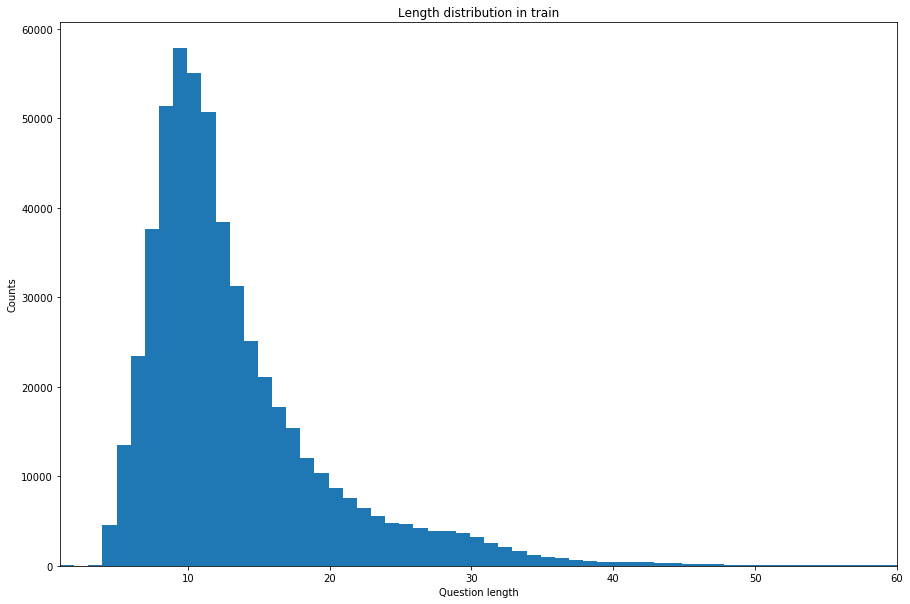

In [18]:
plt.figure(figsize=(15,10))
plt.hist(lens, max(lens))
plt.xlabel('Question length')
plt.ylabel('Counts')
plt.title('Length distribution in train')
plt.xlim(1, 60)
plt.show()

### Fit embeddings to vocabulary

In [19]:
loaded_embeddings.shape

(400000, 300)

In [20]:
embeddings = np.random.normal(scale=0.001, size=(len(w2idx_train), parameters["w_embed_size"]))

if parameters["load_embeds"]:
    for w, i in w2idx_train.items():
        idx = w2idx.get(w)
        if idx is not None:
            embeddings[i] = loaded_embeddings[idx][:parameters["w_embed_size"]]

In [21]:
embeddings

array([[-0.00114735,  0.00073054, -0.0019982 , ...,  0.00081816,
         0.00155539, -0.00102841],
       [-0.20017   ,  0.14302   ,  0.052055  , ...,  0.034939  ,
        -0.12599   ,  0.21863   ],
       [-0.1749    ,  0.22956   ,  0.24924   , ..., -0.24131   ,
        -0.40402001,  0.054744  ],
       ..., 
       [-0.020654  ,  0.051946  , -0.19756   , ..., -0.1902    ,
         0.27513999,  0.45159   ],
       [ 0.31079   ,  0.57249999,  0.10701   , ...,  0.14535999,
         0.57359999,  0.59401   ],
       [-0.43546   , -0.14072999, -0.26552999, ...,  0.42638001,
        -0.03747   ,  0.26030001]])

## 2. Deep Learning Model

In [22]:
batch_size = 8
hidden_size = 1024
drop = 0
padlen = 40
learn = 0.01
epochs = 10

In [23]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [24]:
### Placeholders
q1 = tf.placeholder(tf.int64, shape=[None, padlen], name="question1")
len1 = tf.placeholder(tf.int64, shape=[None], name="len1")

q2 = tf.placeholder(tf.int64, shape=[None, padlen], name="question2")
len2 = tf.placeholder(tf.int64, shape=[None], name="len2")

y = tf.placeholder(tf.int64, shape=[None,2], name="is_duplicate")

dropout = tf.placeholder(dtype=tf.float32, shape=[], name="dropout")
lr = tf.placeholder(dtype=tf.float32, shape=[], name="lr")

In [25]:
def bilstm(seq, seq_len):
    cell_fw = tf.nn.rnn_cell.LSTMCell(hidden_size)
    cell_bw = tf.nn.rnn_cell.LSTMCell(hidden_size)
    (output_fw, output_bw), _ = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, seq,
                                                                sequence_length=seq_len, 
                                                                dtype=tf.float32)
    output = tf.concat([output_fw, output_bw], axis=-1)
    return output


def fc(x, W, b):
    return tf.matmul(x, W)+ b

def activation(x):
    return tf.nn.sigmoid(x)

In [26]:
### Embedding layer
with tf.variable_scope("word_embeddings") as scope:
    _word_embeddings = tf.Variable(embeddings, name="_word_embeddings", dtype=tf.float32, 
                        trainable=1-parameters["freeze"])
    we1 = tf.nn.embedding_lookup(_word_embeddings, q1, name="q1_embedded")
    we2 = tf.nn.embedding_lookup(_word_embeddings, q2, name="q2_embedded")

    we1 = tf.nn.dropout(we1, dropout)
    we2 = tf.nn.dropout(we2, dropout)

In [27]:
### Shared layer
with tf.variable_scope("bilstm") as scope:
    lstm1 = bilstm(we1, len1)
    scope.reuse_variables()    
    lstm2 = bilstm(we2,len2)
        
max_pool = tf.contrib.keras.layers.GlobalMaxPool1D()
        
### Max pooling !!!
lstm1_pool = max_pool(lstm1)
lstm2_pool = max_pool(lstm2)

In [28]:
### Features
flat1 = tf.contrib.layers.flatten(lstm1_pool)
flat2 = tf.contrib.layers.flatten(lstm2_pool)
mult = tf.multiply(flat1, flat2)
diff = tf.abs(tf.subtract(flat1, flat2))    
concat = tf.concat([flat1, flat2, mult, diff], axis=-1)

In [29]:
### FC layers
intermediary_size = 2 + (8*hidden_size - 2) // 2

with tf.variable_scope("fc1") as scope:
    W = tf.Variable(tf.random_normal([8*hidden_size, intermediary_size]), name="w_fc")
    b = tf.Variable(tf.zeros([intermediary_size]), name="b_fc")    
    
    preact = tf.matmul(concat, W) + b
    fc = activation(preact)    
    
#     tf.summary.histogram("weights", W)
    
with tf.variable_scope("fc2") as scope:
    W = tf.Variable(tf.random_normal([intermediary_size, 2]), name="w_fc")
    b = tf.Variable(tf.zeros([2]), name="b_fc")    
    
    preact = tf.matmul(fc, W) + b
    fc = activation(preact)    
    
#     tf.summary.histogram("weights", W)

In [30]:
### Loss & optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=fc))

# train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

In [31]:
### Evaluation
correct_prediction = tf.equal(tf.argmax(fc,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [32]:
class Train_batch_iterator:
    def __init__(self, q1ids, q2ids, sequence_dict, is_duplicate, batch_size, padlen=40):
        self.i = 0
        self.max = len(q1ids)
        
        self.q1ids = q1ids
        self.q2ids = q2ids
        self.sequence_dict = sequence_dict
        self.is_duplicate = is_duplicate
        self.batch_size = batch_size
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.i + self.batch_size < self.max:
            q1 = np.array([pad_sequence(self.sequence_dict[qid1[k]], 0, padlen) 
                           for k in range(self.i, min(self.i + self.batch_size, self.max))])
            len1 = [min(len(self.sequence_dict[qid2[k]]), padlen) for k in range(self.i, min(self.i + self.batch_size, self.max))]
            
            q2 = np.array([pad_sequence(self.sequence_dict[qid1[k]], 0, padlen)
                           for k in range(self.i, min(self.i + self.batch_size, self.max))])
            len2 = [min(len(self.sequence_dict[qid2[k]]), padlen) for k in range(self.i, min(self.i + self.batch_size, self.max))]
            
            y = np.concatenate([np.expand_dims(1-is_duplicate[self.i: self.i + self.batch_size], axis=1), 
                                np.expand_dims(is_duplicate[self.i: self.i + self.batch_size], axis=1)], axis=-1)
            
            self.i += self.batch_size
            return q1, q2, len1, len2, y
        else:
            raise StopIteration()

In [33]:
with tf.name_scope('summaries'):
    ce_summary = tf.summary.scalar('cross_entropy', cross_entropy)
    acc_summary = tf.summary.scalar('train_batch_accuracy', accuracy)
    
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('tensorboard_logs/train', sess.graph)
    test_writer = tf.summary.FileWriter('tensorboard_logs/test', sess.graph)

In [34]:
saver = tf.train.Saver()

In [35]:
print(len(qid1)//batch_size)

50536


In [36]:
batch_iter = Train_batch_iterator(qid1, qid2, sequences, is_duplicate, batch_size, padlen)

### Test
x1, x2, l1, l2, is_dup = batch_iter.__next__()
fd_test = {q1: x1, q2: x2, len1: l1, len2: l2, y: is_dup, dropout: 0, lr: learn}


### Training
sess.run(tf.global_variables_initializer())

for epoch in range(1, epochs+1):
    for i, (x1, x2, l1, l2, is_dup) in enumerate(batch_iter):
        fd_train = {q1: x1, q2: x2, len1: l1, len2: l2, y: is_dup, dropout: drop, lr: learn}
        summary, _ = sess.run([summary_op, train_step], feed_dict=fd_train)
        train_writer.add_summary(summary, i+(epoch-1)*len(qid1))
        save_path = saver.save(sess, "saved/model.ckpt")
        
        
        if i % 100 == 0:
            summary, acc = sess.run([summary_op, accuracy], feed_dict=fd_test)
            print("Epoch {}/{} step {}/{}  acc: {}".format(epoch, epochs, i,len(qid1)//batch_size, acc))
            test_writer.add_summary(summary, i+(epoch-1)*len(qid1))

Epoch 1/10 step 0/50536  acc: 0.25


KeyboardInterrupt: 